# Data Collection

In [ ]:
# Imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import precision_recall_curve

In [ ]:
# Spotify authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id = "93dc1d8b704a44bbb7838960cab9e3f6", client_secret="78ac04b521374940b4f1a7568ef440ac")
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

In [ ]:
# Function to extract songs and artists data from a playlist thats longer than 100 songs 
# adapted from : https://stackoverflow.com/questions/39086287/spotipy-how-to-read-more-than-100-tracks-from-a-playlist 
# we added the code to extract artist data alongside songs data
def get_playlist_tracks_more_than_100_songs(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    results = tracks    

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_first_release_date = []
    playlist_tracks_popularity = []

    for i in range(len(results)):
        print(i) 
        if i == 0:
            playlist_tracks_id = results[i]['track']['id']
            playlist_tracks_titles = results[i]['track']['name']
            playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
            playlist_tracks_popularity = results[i]['track']['popularity']
            
            #artist info 
            for artist in results[i]['track']['artists']: 
                artist_uri = artist["uri"]
                artist_info = sp.artist(artist_uri)
                artist_pop = artist_info["popularity"]
                artist_genres = artist_info["genres"]
    
            artist_list = []
            artist_ids = []
            artist_df = pd.DataFrame(columns=["id","followers","genres", "popularity"])
            for artist in results[i]['track']['artists']:
                artist_list.append(artist['name'])
                artist_ids.append(artist['id'])
                artist_uri = artist["uri"]
                artist_info = sp.artist(artist_uri)
                artist_df.loc[len(artist_df.index)] = [artist['id'],artist_info["followers"]["total"],artist_info['genres'],artist_info['popularity']] 

                
            playlist_tracks_artists = [artist_list]
            playlist_tracks_artists_ids = [artist_ids]
            features = sp.audio_features(playlist_tracks_id)
            features_df = pd.DataFrame(data=features, columns=features[0].keys())
            features_df['title'] = playlist_tracks_titles
            features_df['all_artists'] = playlist_tracks_artists
            features_df['artist_id'] = playlist_tracks_artists_ids
            features_df['popularity'] = playlist_tracks_popularity
            features_df['release_date'] = playlist_tracks_first_release_date
            features_df = features_df[['id', 'title', 'all_artists', 'artist_id', 'popularity', 'release_date',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'acousticness', 'instrumentalness',
                                       'liveness', 'valence', 'tempo',
                                       'duration_ms', 'speechiness']]
            continue
        else:
            try:
                playlist_tracks_id = results[i]['track']['id']
                playlist_tracks_titles = results[i]['track']['name']
                playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
                playlist_tracks_popularity = results[i]['track']['popularity']
                artist_list = []
                artist_ids = []
                for artist in results[i]['track']['artists']:
                    artist_list.append(artist['name'])
                    artist_ids.append(artist['id'])
                    artist_uri = artist["uri"]
                    artist_info = sp.artist(artist_uri)
                    artist_df.loc[len(artist_df.index)] = [artist['id'],artist_info["followers"]["total"],artist_info['genres'],artist_info['popularity']]
                    
                playlist_tracks_artists = artist_list
                playlist_tracks_artists_ids = artist_ids
                features = sp.audio_features(playlist_tracks_id)
                new_row = {'id':[playlist_tracks_id],
               'title':[playlist_tracks_titles],
               'all_artists':[playlist_tracks_artists],
               'artist_id':[playlist_tracks_artists_ids] ,          
               'popularity':[playlist_tracks_popularity],
               'release_date':[playlist_tracks_first_release_date],
               'danceability':[features[0]['danceability']],
               'energy':[features[0]['energy']],
               'key':[features[0]['key']],
               'loudness':[features[0]['loudness']],
               'acousticness':[features[0]['acousticness']],
               'instrumentalness':[features[0]['instrumentalness']],
               'liveness':[features[0]['liveness']],
               'valence':[features[0]['valence']],
               'tempo':[features[0]['tempo']],
               'duration_ms':[features[0]['duration_ms']],
               'speechiness':[features[0]['speechiness']]
               }

                dfs = [features_df, pd.DataFrame(new_row)]
                features_df = pd.concat(dfs, ignore_index = True)
            except:
                continue
                
    return features_df, artist_df


In [ ]:
# List of playlists to extract songs from. We tried to gather more and less popular songs to obtain a relatively balanced dataset.
playlist_list = ['37i9dQZEVXbNG2KDcFcKOF', '6yImYsbkCf434ENFO498Bq', '37i9dQZF1DX9XIFQuFvzM4', '37i9dQZF1DX5Ejj0EkURtP', '37i9dQZF1DX1lVhptIYRda', '37i9dQZF1DX10zKzsJ2jva', '37i9dQZF1DWU8quswnFt3c', '37i9dQZF1DX873GaRGUmPl', '37i9dQZF1DX9XIFQuFvzM4', '37i9dQZF1DWYV7OOaGhoH0', '37i9dQZF1DWTcqUzwhNmKv', '37i9dQZF1DXbITWG1ZJKYt', '6yPiKpy7evrwvZodByKvM9' ]

In [ ]:
# Fill the songs and artists dataframes (features_df and artist_df respectively)
artist_df = pd.DataFrame(columns=["id","followers","genres", "popularity"])
features_df = pd.DataFrame(columns=['id', 'title', 'all_artists', 'artist_id', 'popularity', 'release_date',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'acousticness', 'instrumentalness',
                                       'liveness', 'valence', 'tempo',
                                       'duration_ms', 'speechiness'])

for playlist in playlist_list:
    features_df1, artist_df1 = get_playlist_tracks_more_than_100_songs('31hsihklern6kxv5zfzmnal4pppm', playlist)
    features_df = features_df.append(features_df1, ignore_index=True)
    artist_df = artist_df.append(artist_df1, ignore_index=True)

In [ ]:
#Save the dataframes loally
artist_df.to_csv("C:/Users/alesi/Documents/spotify_project/artists_new.csv", index = False)
features_df.to_csv("C:/Users/alesi/Documents/spotify_project/songs_new.csv", index = False)

# Data pre-processing and feature engineering

In [ ]:
# Load songs and artists datasets from Kaggle to join with the data we collected
# link: https://www.kaggle.com/competitions/sliced-s01e08-KJSEks/data
songs_df1 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/songs_new.csv").replace('\'','', regex=True)
artist_df1 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/artists_new.csv").replace('\'','', regex=True) 
songs_df2 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/train.csv").replace('\'','', regex=True)
artist_df2 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/artists.csv").replace('\'','', regex=True)
songs_df2 = songs_df2.drop(songs_df2.columns[0], axis=1)
artist_df2 = artist_df2.drop(songs_df2.columns[0], axis=1)

In [ ]:
# Delete artists name column from songs_df1 and songs_df2 (the ids are enough to identify artists)
songs_df1.drop(columns= ["all_artists"], inplace = True)
songs_df2.drop(columns= ["artists"], inplace = True)


In [ ]:
# Split release date into three separate columns
songs_df1 = songs_df1.join(songs_df1['release_date'].str.split('-', expand=True).rename(columns={0:'release_year', 1:'release_month', 2:'release_day'}))

In [ ]:
songs_df2["release_year"] = songs_df2["release_year"].astype('Int64')
songs_df2["release_month"] = songs_df2["release_month"].astype('Int64')
songs_df2["release_day"] = songs_df2["release_day"].astype('Int64')

songs_df1["release_year"] = songs_df1["release_year"].astype('Int64')
songs_df1["release_month"] = songs_df1["release_month"].astype('Int64')
songs_df1["release_day"] = songs_df1["release_day"].astype('Int64')

In [ ]:
songs_df1.rename(columns={"title": "name", "artist_id": "id_artists"}, inplace= True)

In [ ]:
songs_df1.drop(['id', 'release_date'], axis=1, inplace = True)

In [ ]:
# Merge the dataset we collected with the one from Kaggle 
songs_df = pd.concat([songs_df1, songs_df2], ignore_index=True)

In [ ]:
# Drop songs duplicates after merging the two dataframes
songs_df = songs_df.drop_duplicates(subset = ['name', 'id_artists'],keep = 'last').reset_index(drop = True)

In [ ]:
artist_df2.drop(['Unnamed: 0'], axis=1, inplace = True)

In [ ]:
# Merge the two artists datasets
artist_df = pd.concat([artist_df1, artist_df2], ignore_index=True)

In [ ]:
# Drop artists duplicates
artist_df = artist_df.drop_duplicates(subset = ['id'],keep = 'last').reset_index(drop = True)

In [ ]:
# Create dictionary matching artist id with popularity and followers repsectively
artist_popularity_dic = dict(zip(artist_df["id"], artist_df["popularity"]))
artist_followers_dic = dict(zip(artist_df["id"], artist_df["followers"]))

In [ ]:
# Create dictionary matching artist id with the genres for that specific artist
genre_dic = defaultdict(list)
id_genre_dic = dict()

for i, row in artist_df.iterrows():
    genre_list = str(row["genres"]).replace("[", "").replace("]","").replace("'", "").split()
    for entry in genre_list:
        genre_dic[entry].append(row["popularity"])
    id_genre_dic[row["id"]] = genre_list

In [ ]:
id_genre_dic

In [ ]:
# Create list with the most occurring genres in the dataframes, as well as the ones associated with the highest popularity
genre_counts = sorted([(p, len(genre_dic[p])) for p in genre_dic], key=lambda x:x[1], reverse=True)
valid_genres = [g[0] for g in genre_counts[0:1000]]
top_genres = [g[0] for g in genre_counts[0:200]]
popularity_sorted = sorted([(p, np.mean(genre_dic[p])) for p in genre_dic if p in valid_genres], key=lambda x:x[1], reverse=True)
popular_genres = [p[0] for p in popularity_sorted[0:200]]

In [ ]:
def calc_popularity_for_artist(id_list, flag):
    popularity_scores = list()
    for entry in id_list:
        if entry in artist_popularity_dic:
            popularity_scores.append(artist_popularity_dic[entry])
        else:
            popularity_scores.append(0)
    if flag == "max":
        return max(popularity_scores)
    else:
        return np.mean(popularity_scores)

In [ ]:
def calc_followers_for_artist(id_list, flag):
    follower_scores = list()
    for entry in id_list:
        if entry in artist_followers_dic:
            follower_scores.append(artist_followers_dic[entry])
        else:
            follower_scores.append(0)
    if flag == "max":
        return max(follower_scores)
    else:
        return np.mean(follower_scores)

In [ ]:
# Since many of our songs are features of collaborations, it is useful to compute the mean and max for popularity and followers of all artists involved in each song
songs_df["artist_list"] = songs_df["id_artists"].map(lambda x: str(x).replace("[", "").replace("]","").replace("'", "").split())

for i, row in songs_df.iterrows():
    mod_string = row["artist_list"]
    if len(row["artist_list"])>1:
        l=[]
        t=0
        for element in row["artist_list"]:
            if t==len(row["artist_list"])-1:
                l.append(row["artist_list"][len(row["artist_list"])-1])
                break
            size = len(row["artist_list"][t])
            mod_string = element[:size - 1]
            l.append(mod_string)
            t+=1
        songs_df.at[i,'artist_list'] = l

songs_df["feature_max_artist_popularity"] = songs_df["artist_list"].map(lambda x: calc_popularity_for_artist(x, flag="max"))
songs_df["feature_mean_artist_popularity"] = songs_df["artist_list"].map(lambda x: calc_popularity_for_artist(x, flag="mean"))


In [ ]:
songs_df["feature_max_artist_followers"] = songs_df["artist_list"].map(lambda x: calc_followers_for_artist(x, flag="max"))
songs_df["feature_mean_artist_followers"] = songs_df["artist_list"].map(lambda x: calc_followers_for_artist(x, flag="mean"))

In [ ]:
def map_genres(id_list, flag):
    genres = list()
    for entry in id_list:
        if entry in id_genre_dic:
            if flag == "valid":
                genres += [i for i in id_genre_dic[entry] if i in valid_genres]
            elif flag == "popular":
                genres += [i for i in id_genre_dic[entry] if i in popular_genres]
            else:
                genres += [i for i in id_genre_dic[entry] if i in top_genres]
    genres = list(set(genres))
    if len(genres) > 0:
        return "_".join(sorted(genres))
    else:
        return "none"

In [ ]:
# Create features containing genres for each song (genres associated to all the artists involved in the song)
# Valid genres indicate genres applicable to the song, top genres are the ones occurring with highest frequency, popular genres are the ones associated with the most popular songs.
songs_df["genre_flag_valid"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="valid"))
songs_df["genre_flag_top"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="top"))
songs_df["genre_flag_popular"] = songs_df["artist_list"].map(lambda x: map_genres(x, flag="popular"))
songs_df["feature_genre_valid_flag"] = songs_df["genre_flag_valid"].astype("category")
songs_df["feature_genre_top_flag"] = songs_df["genre_flag_top"].astype("category")
songs_df["feature_genre_flag_popular"] = songs_df["genre_flag_popular"].astype("category")

In [ ]:
songs_df['id_artists'] = songs_df['id_artists'].str.strip('[]').str.split(',')

In [ ]:
df = pd.DataFrame(songs_df['id_artists'].values.tolist()).add_prefix('artist_')

In [ ]:
songs_df = pd.merge(songs_df, df['artist_0'], left_index=True, right_index=True)

In [ ]:
# Merge songs and artist dataframes
train_df = songs_df.merge(artist_df,left_on=['artist_0'],right_on=['id'],how='inner')

In [ ]:
train_df['duration_ms'] = train_df['duration_ms']/1000/60

In [ ]:
for i in range(27):
 train_df['genres']=train_df['genres'].apply(lambda x: x[1:] if x.startswith(",") else x)
 train_df['genres']=train_df['genres'].apply(lambda x: x[1:] if x.startswith(" ") else x)

In [ ]:
train_df.rename(columns={"duration_ms": "duration", "popularity_x": "popularity_song","popularity_y":"popularity_artist"}, inplace=True)

In [ ]:
train_df['genres'] = train_df['genres'].str.split(',')

In [ ]:
df = pd.DataFrame(train_df['genres'].values.tolist()).add_prefix('genre_')

In [ ]:
train_df = pd.merge(train_df, df, left_index=True, right_index=True)

In [ ]:
cols=[]
for i in range(18):
    cols.append(f"genre_{i}")
train_df["all"] = train_df[cols].apply(lambda x: ','.join(x.dropna()), axis=1)
train_df['all'] = train_df['all'].str.split(',')

In [ ]:
# Create dummy variables for some of the top genres, indicating if a song belongs to that specific genre 
# (Note that this takes a lot to run so we saved the dataframe locally in the next cell so we would not have to re-run each time)
genres = ["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul"]
train_df1 = train_df.copy()
for g in genres:
    train_df[g] = 0

    for index,row in train_df1.iterrows():
        t = False
        nn=len(row["all"])
        end=19+nn
        for col in train_df1.iloc[:,22:40]:
            if g is not None and isinstance(row[col], str):
                one = g.split()
                two = row[col].split()
                common = set(one).intersection(set(two))
                unique = set(one).symmetric_difference(set(two))
            if len(common)>0:
                t = True
        if t == True:
            train_df1.loc[index, g ] = 1

In [ ]:
# Save the new dataframe locally 
train_df1.to_csv("C:/Users/alesi/Documents/spotify_project/train_df1_final1.csv", index = False)

In [220]:
# Load the dataframe
train_df1 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/train_df1_final1.csv")

C:\Users\alesi\AppData\Local\Temp\ipykernel_1884\3414089250.py:2: DtypeWarning: Columns (56,57,58) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df1 = pd.read_csv("C:/Users/alesi/Documents/spotify_project/train_df1_final1.csv")


In [221]:
train_df1[["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul", 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers']] = train_df1[["pop", "r&b", "trap", "rap", "edm", "adult standards", "folk", "classical", "reggae", "jazz", "rock", "latin", "soul", 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers']].fillna(0).astype(int)

In [222]:
# Drop features that are not needed anymore for the analysis
for i in range(18):
    train_df1.drop(columns = [f"genre_{i}"], inplace = True)
train_df1.drop (columns = ["name", "id_artists", "id", "genres", "artist_0", "all"], inplace = True)

In [223]:
train_df1.columns

Index(['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'release_year', 'release_month',
       'release_day', 'artist_list', 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'genre_flag_valid', 'genre_flag_top',
       'genre_flag_popular', 'feature_genre_valid_flag',
       'feature_genre_top_flag', 'feature_genre_flag_popular', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul'],
      dtype='object')

# Exploratory data analysis and more feature engineering

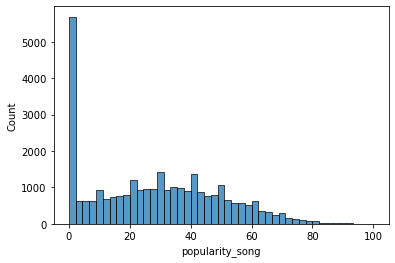

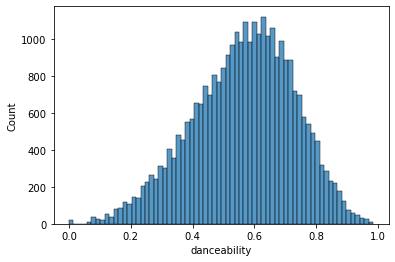

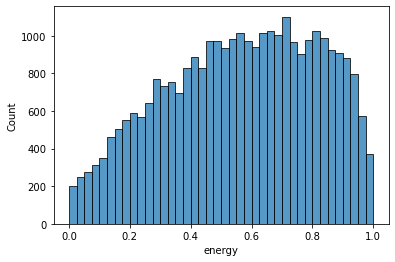

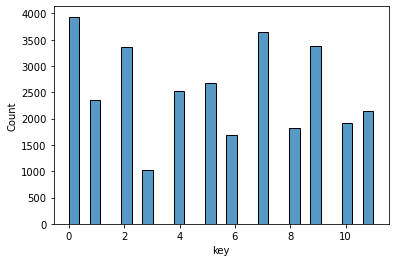

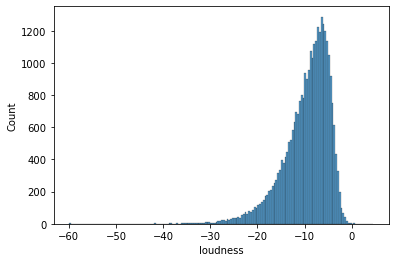

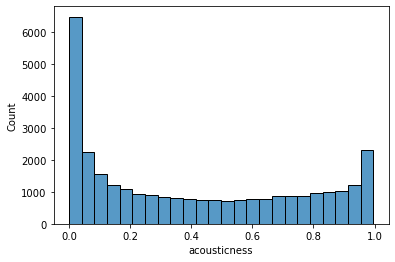

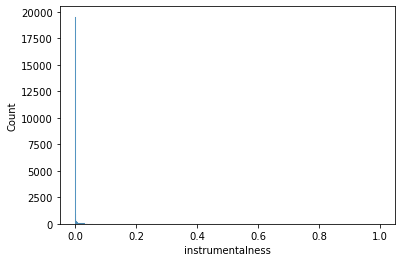

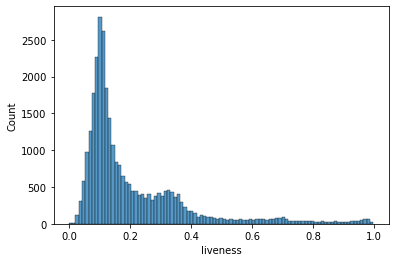

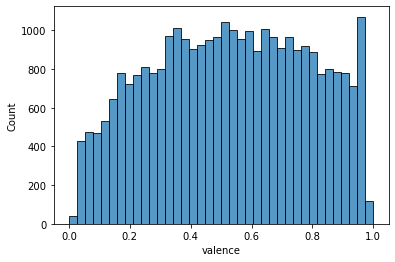

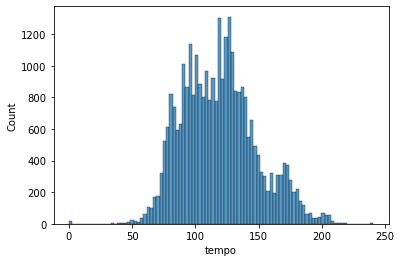

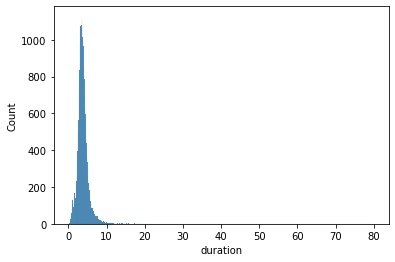

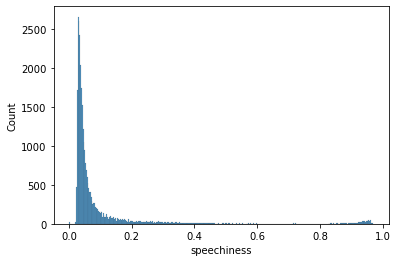

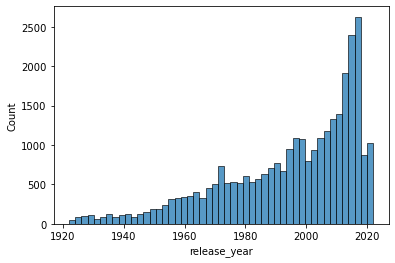

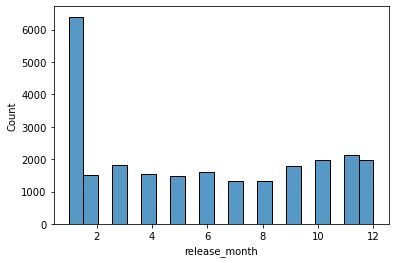

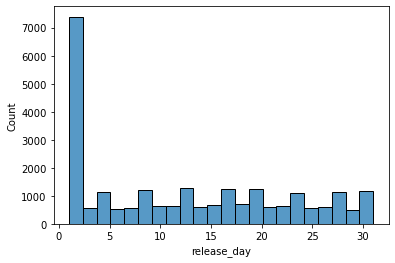

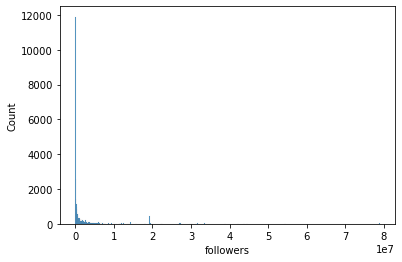

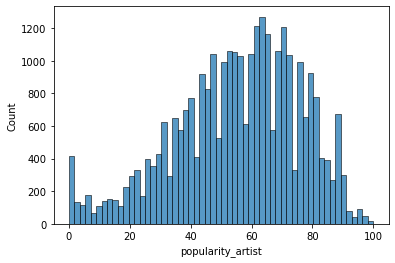

In [224]:
# Distribution of the features
cols = ['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'release_year', 'release_month',
       'release_day', 'followers', 'popularity_artist']
for column in cols:
    fig, axes = plt.subplots(1,1)
    sns.histplot(train_df1[column])

In [225]:
# Take log of right-skewed features
train_df1["log_duration"] = train_df1["duration"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_speechiness"] = train_df1["speechiness"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_instrumentalness"] = train_df1["instrumentalness"].map(lambda x: np.log(x) if x > 0 else 0)
train_df1["log_liveness"] = train_df1["liveness"].map(lambda x: np.log(x) if x > 0 else 0)

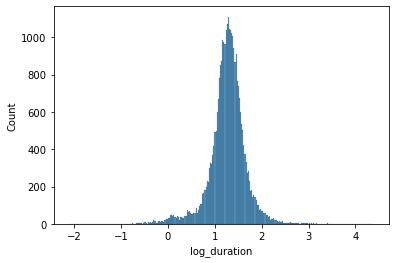

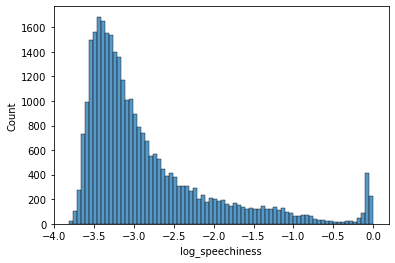

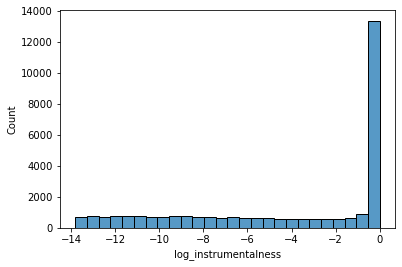

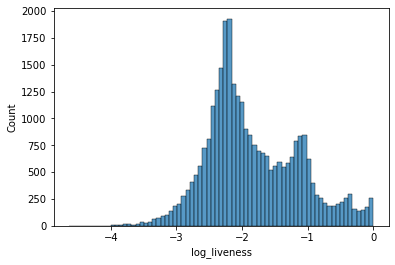

In [226]:
#  New distributions
cols = ["log_duration", "log_speechiness", "log_instrumentalness", "log_liveness"]
for column in cols:
    fig, axes = plt.subplots(1,1)
    sns.histplot(train_df1[column])

C:\Users\alesi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alesi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alesi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alesi\anaconda3\lib\si

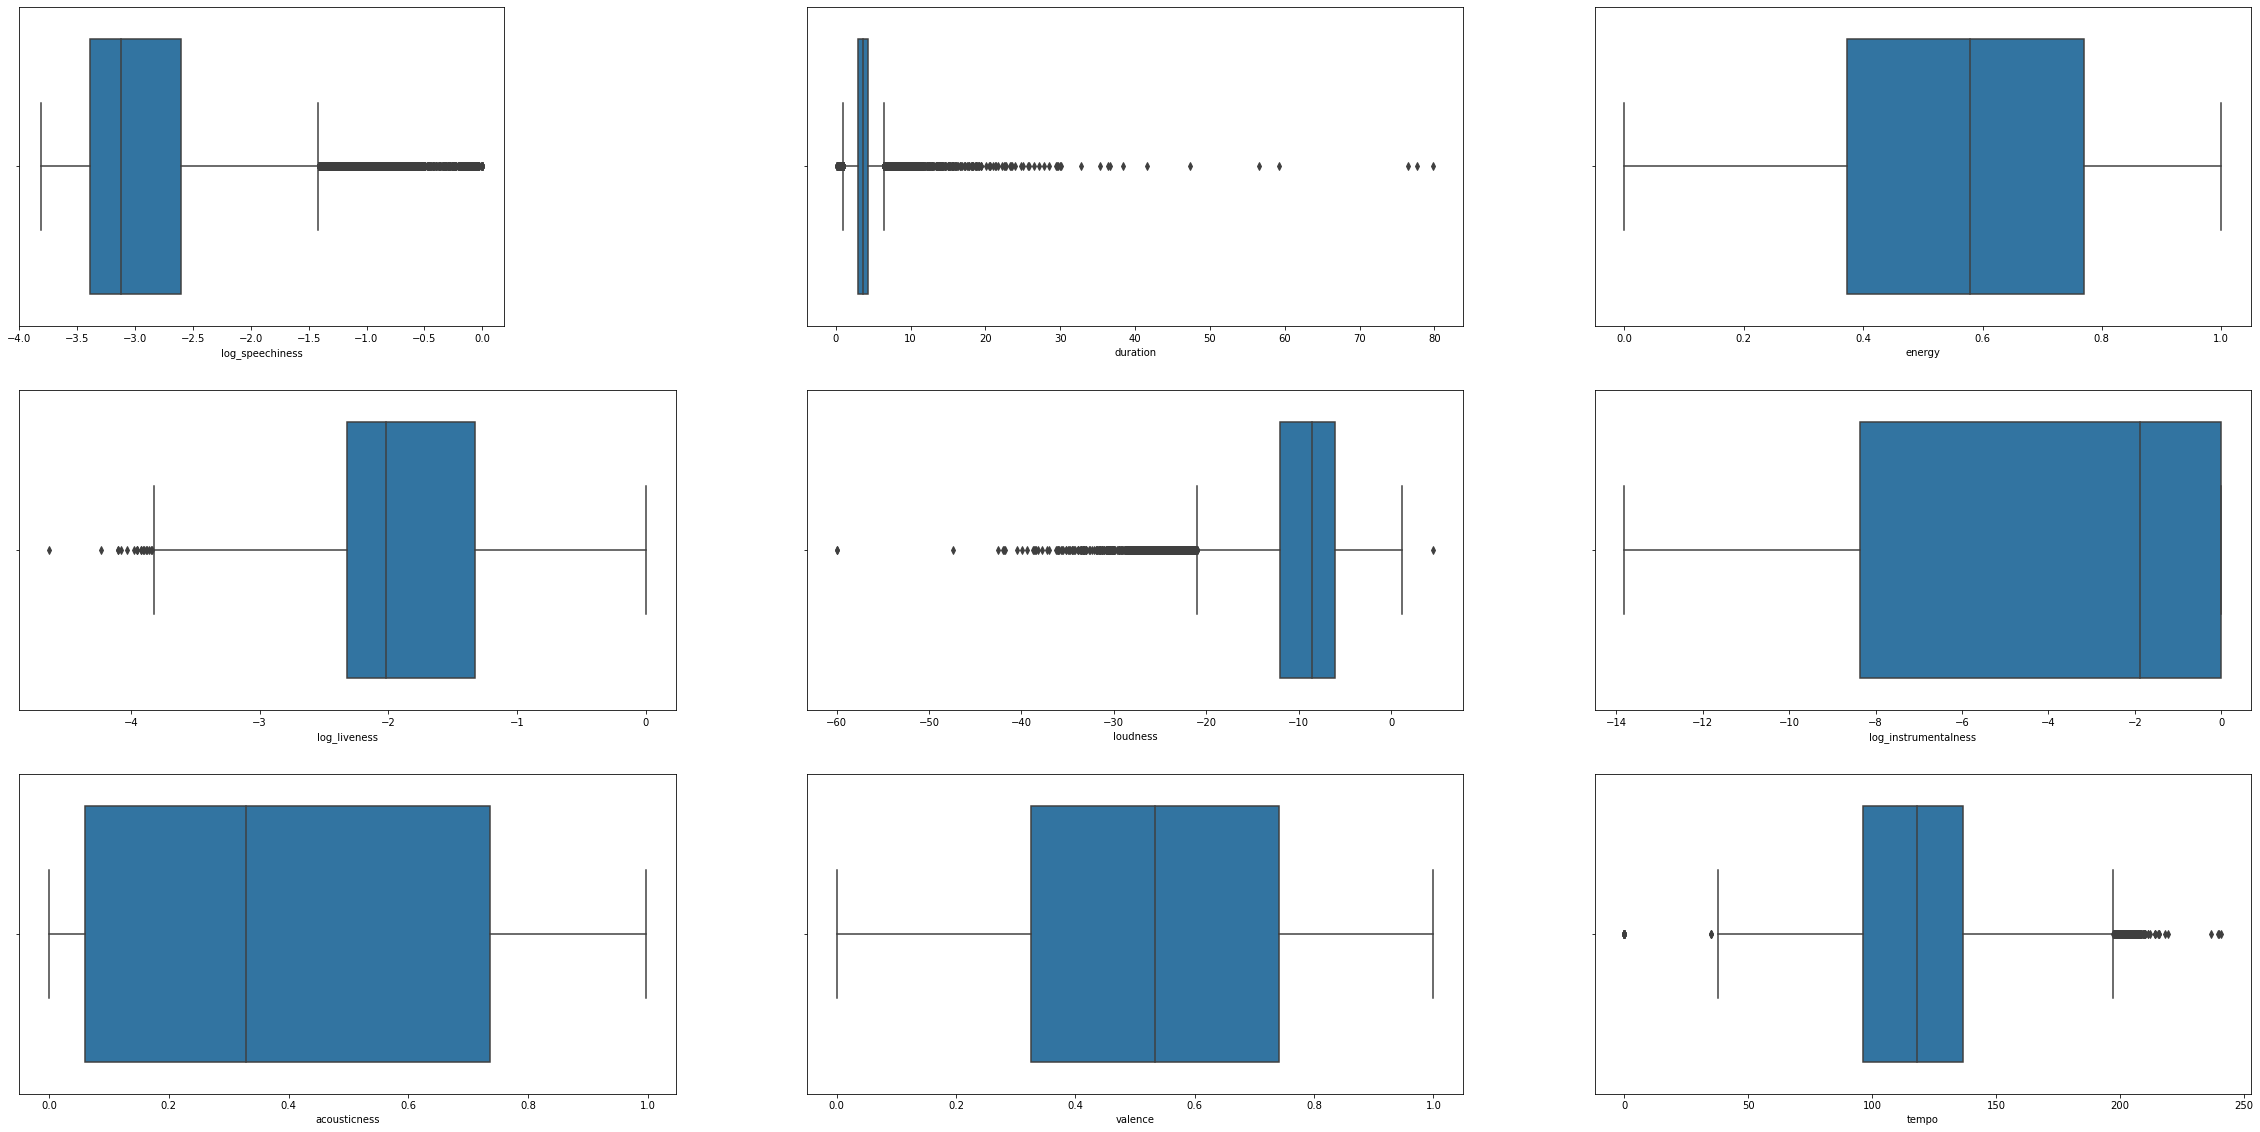

In [227]:
plt.figure(figsize = (40, 20))
plt.subplot(331)
sns.boxplot(train_df1['danceability'])
plt.subplot(332)
sns.boxplot(train_df1['duration'])
plt.subplot(333)
sns.boxplot(train_df1['energy'])
plt.subplot(334)
sns.boxplot(train_df1['log_liveness'])
plt.subplot(335)
sns.boxplot(train_df1['loudness'])
plt.subplot(336)
sns.boxplot(train_df1['log_instrumentalness'])
plt.subplot(337)
sns.boxplot(train_df1['acousticness'])
plt.subplot(338)
sns.boxplot(train_df1['valence'])
plt.subplot(339)
sns.boxplot(train_df1['tempo'])
plt.subplot(341)
sns.boxplot(train_df1['log_speechiness'])
plt.show()

<AxesSubplot:xlabel='key', ylabel='popularity_song'>

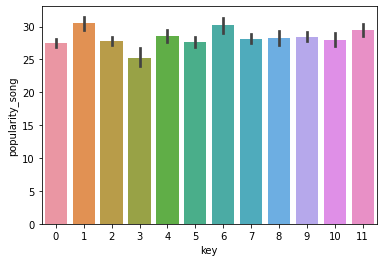

In [228]:
# Plot popularity of the song based on key
sns.barplot(x = 'key', y = 'popularity_song', data = train_df1)

In [229]:
train_df1.columns

Index(['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'release_year', 'release_month',
       'release_day', 'artist_list', 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'genre_flag_valid', 'genre_flag_top',
       'genre_flag_popular', 'feature_genre_valid_flag',
       'feature_genre_top_flag', 'feature_genre_flag_popular', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness'],
      dtype='object')

In [230]:
train_df1["feature_key"] = train_df1["key"].map(lambda x: f"k{x}")
train_df1["feature_release_month"] = train_df1["release_month"].map(lambda x: f"m{x}")
train_df1["feature_key"] = train_df1["feature_key"].astype("category")
train_df1["feature_release_month"] = train_df1["feature_release_month"].astype("category")

In [231]:
# Building new features

numerators = ["danceability", "energy", "release_year"]
denominators = ["acousticness", "log_instrumentalness"]

for numerator, denominator in itertools.product(numerators, denominators):
    
    h = f"feature_{numerator}_vs_{denominator}"
    train_df1[h] = train_df1.apply(lambda x: x[numerator] / float(x[denominator]) if x[denominator] != 0 else 0, axis=1)
    
    
    if f"feature_{numerator}" not in train_df1.columns.values:
        train_df1[f"feature_{numerator}"] = train_df1[numerator]
 
    
    if f"feature_{denominator}" not in train_df1.columns.values:
        train_df1[f"feature_{denominator}"] = train_df1[denominator]
   
train_df1[f"feature_log_duration"] = train_df1["log_duration"]
train_df1[f"feature_tempo"] = train_df1["tempo"]
train_df1[f"feature_valence"] = train_df1["valence"]
train_df1[f"feature_log_speechiness"] = train_df1["log_speechiness"]
train_df1[f"feature_log_liveness"] = train_df1["log_liveness"]
train_df1[f"feature_followers"] = train_df1["followers"]


In [232]:
feature_headers = [f for f in train_df1.columns.values if f.find("feature_") != -1]

In [233]:
train_df1["popularity_song"].quantile(0.90)

58.0

In [234]:
train_df1.columns

Index(['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'release_year', 'release_month',
       'release_day', 'artist_list', 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'genre_flag_valid', 'genre_flag_top',
       'genre_flag_popular', 'feature_genre_valid_flag',
       'feature_genre_top_flag', 'feature_genre_flag_popular', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness', 'feature_key',
       'feature_release_month', 'feature_danceability_vs_acousticness',
       'feature_danceability', 'feature_acousticness',
       'feature_danceability_vs_log_instrumental

# Models

In [235]:
# Label the top 10% songs as popular for classification
train_df1.loc[train_df1['popularity_song'] < 58, 'popularity_song'] = 0 
train_df1.loc[train_df1['popularity_song'] >= 58, 'popularity_song'] = 1
train_df1.loc[train_df1['popularity_song'] == 1]

,popularity_song,danceability,energy,key,loudness,acousticness,instrumentalness,liveness,valence,tempo,...,feature_energy_vs_log_instrumentalness,feature_release_year_vs_acousticness,feature_release_year,feature_release_year_vs_log_instrumentalness,feature_log_duration,feature_tempo,feature_valence,feature_log_speechiness,feature_log_liveness,feature_followers
0,1,0.520,0.731,6,-5.338,0.34200,0.001010,0.311,0.662,173.930,...,-0.105976,5912.280702,2022,-293.136732,1.025462,173.930,0.662,-2.887775,-1.167962,14086781
1,1,0.548,0.816,0,-4.209,0.12200,0.000000,0.335,0.557,95.390,...,0.000000,16549.180328,2019,0.000000,1.064711,95.390,0.557,-3.068303,-1.093625,14086781
2,1,0.676,0.771,8,-3.675,0.02370,0.000007,0.102,0.569,99.048,...,-0.064956,85189.873418,2019,-170.098397,1.239017,99.048,0.569,-3.030324,-2.282782,14086781
3,1,0.905,0.563,8,-6.135,0.02540,0.000010,0.113,0.324,106.998,...,-0.048777,79606.299213,2022,-175.180899,1.064412,106.998,0.324,-2.282782,-2.180367,1859356
4,1,0.591,0.764,1,-5.484,0.03830,0.000000,0.103,0.478,169.928,...,0.000000,52767.624021,2021,0.000000,0.860115,169.928,0.478,-3.030324,-2.273026,1624015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30359,1,0.752,0.673,10,-5.792,0.05380,0.000000,0.133,0.350,164.009,...,0.000000,37546.468401,2020,0.000000,1.004924,164.009,0.350,-1.877317,-2.017406,3657199
30366,1,0.557,0.843,0,-4.338,0.00366,0.000002,0.218,0.547,138.339,...,-0.063810,541803.278689,1983,-150.099977,1.197955,138.339,0.547,-2.032558,-1.523260,1666367
30409,1,0.815,0.412,0,-9.280,0.36200,0.000480,0.129,0.669,87.983,...,-0.053915,5538.674033,2005,-262.375333,1.294604,87.983,0.669,-3.128121,-2.047943,38300
30421,1,0.850,0.598,4,-9.770,0.12400,0.007710,0.108,0.697,100.020,...,-0.122913,16282.258065,2019,-414.984915,1.057825,100.020,0.697,-1.579879,-2.225624,64382


In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [253]:
features = ['feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'feature_danceability_vs_acousticness',
       'feature_danceability', 'feature_acousticness',
       'feature_danceability_vs_log_instrumentalness',
       'feature_log_instrumentalness', 'feature_energy_vs_acousticness',
       'feature_energy', 'feature_energy_vs_log_instrumentalness',
       'feature_release_year_vs_acousticness', 'feature_release_year',
       'feature_release_year_vs_log_instrumentalness', 'feature_log_duration',
       'feature_tempo', 'feature_valence', 'feature_log_speechiness',
       'feature_log_liveness', 'feature_followers']

In [254]:
X_train = train_df1[features]
y_train = train_df1['popularity_song']

In [255]:
train_df1.columns

Index(['popularity_song', 'danceability', 'energy', 'key', 'loudness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration', 'speechiness', 'release_year', 'release_month',
       'release_day', 'artist_list', 'feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers', 'genre_flag_valid', 'genre_flag_top',
       'genre_flag_popular', 'feature_genre_valid_flag',
       'feature_genre_top_flag', 'feature_genre_flag_popular', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul', 'log_duration', 'log_speechiness',
       'log_instrumentalness', 'log_liveness', 'feature_key',
       'feature_release_month', 'feature_danceability_vs_acousticness',
       'feature_danceability', 'feature_acousticness',
       'feature_danceability_vs_log_instrumental

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 420)

In [257]:
LR_Model = LogisticRegression()
LR_Model.fit(X_train, y_train)
LR_Predict = LR_Model.predict(X_test)
LR_Accuracy = accuracy_score(y_test, LR_Predict)
print("Accuracy: " + str(LR_Accuracy))

LR_AUC = roc_auc_score(y_test, LR_Predict) 
print("AUC: " + str(LR_AUC))

Accuracy: 0.8970274265068156
AUC: 0.522142937844084


C:\Users\alesi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [267]:
RFC_Model = RandomForestClassifier()
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_test)
RFC_Accuracy = accuracy_score(y_test, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

RFC_AUC = roc_auc_score(y_test, RFC_Predict) 
print("AUC: " + str(RFC_AUC))

Accuracy: 0.9106585646247332
AUC: 0.599342428657369


In [268]:
param_dict = {'criterion' : ['gini'], 'max_depth': range(3,10), 'min_samples_split': range(2,10), 'min_samples_leaf':range(1,5)}

In [269]:
grid = GridSearchCV (DT_Model, param_grid = param_dict, cv=10, verbose=2)
grid.fit(X_train, y_train)

Fitting 10 folds for each of 224 candidates, totalling 2240 fits
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.2s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_leaf=1, min_samples_split=2; total time=   0.3s
[CV] END criterion=gini, max_depth=3, min_samples_lea

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(3, 10),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 10)},
             verbose=2)

In [270]:
grid.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'min_samples_leaf': 3,
 'min_samples_split': 4}

In [271]:
DT_Model = DecisionTreeClassifier(criterion = "gini", max_depth=6, min_samples_leaf=3, min_samples_split=4)
DT_Model.fit(X_train, y_train)
DT_Predict = DT_Model.predict(X_test)
DT_Accuracy = accuracy_score(y_test, DT_Predict)
print("Accuracy: " + str(DT_Accuracy))

DT_AUC = roc_auc_score(y_test, DT_Predict) 
print("AUC: " + str(DT_AUC))

Accuracy: 0.9086877976679257
AUC: 0.5982457370105038


In [273]:
XGB_Model = XGBClassifier(objective = "binary:logistic", n_estimators = 10, seed = 123)
XGB_Model.fit(X_train, y_train)
XGB_Predict = XGB_Model.predict(X_test)
XGB_Accuracy = accuracy_score(y_test, XGB_Predict)
print("Accuracy: " + str(XGB_Accuracy))

XGB_AUC = roc_auc_score(y_test, XGB_Predict) 
print("AUC: " + str(XGB_AUC))

[00:58:50] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.9068812612908523
AUC: 0.583604696490291


# Categorical boosting

In [ ]:
catboost fit --learn-set train --test-set test --column-description train.cd  --loss-function Logloss --custom-loss="AUC,Precision,Recall" -i 4 --logging-level Verbose

In [276]:
features = ['feature_max_artist_popularity',
       'feature_mean_artist_popularity', 'feature_max_artist_followers',
       'feature_mean_artist_followers',
       'feature_genre_valid_flag',
       'feature_genre_top_flag', 'feature_genre_flag_popular', 'followers',
       'popularity_artist', 'pop', 'r&b', 'trap', 'rap', 'edm',
       'adult standards', 'folk', 'classical', 'reggae', 'jazz', 'rock',
       'latin', 'soul',  'feature_key',
       'feature_release_month', 'feature_danceability_vs_acousticness',
       'feature_danceability', 'feature_acousticness',
       'feature_danceability_vs_log_instrumentalness',
       'feature_log_instrumentalness', 'feature_energy_vs_acousticness',
       'feature_energy', 'feature_energy_vs_log_instrumentalness',
       'feature_release_year_vs_acousticness', 'feature_release_year',
       'feature_release_year_vs_log_instrumentalness', 'feature_log_duration',
       'feature_tempo', 'feature_valence', 'feature_log_speechiness',
       'feature_log_liveness', 'feature_followers']
X_train = train_df1[features]
y_train = train_df1['popularity_song']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = 420)

In [277]:
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
cat_features = ["feature_key",
                "feature_release_month",
                "feature_genre_valid_flag",
                "feature_genre_top_flag",
                "feature_genre_flag_popular"]
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=6, l2_leaf_reg= 9)
# Fit model
model.fit(X_train[features], y_train, cat_features)
# Get predicted classes
preds_class = model.predict(X_test[features])
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test[features])
# Get predicted RawFormulaVal
preds_raw = model.predict(X_test[features], prediction_type='RawFormulaVal')
print(model.get_best_score())

print(auc)
print(model.score(preds_class, y_test))
fpr, tpr, _ = roc_curve(y_test, preds_proba[:,1])
roc_auc = auc(fpr,tpr)

0:	learn: 0.5844943	total: 97.8ms	remaining: 9.68s
1:	learn: 0.4913939	total: 183ms	remaining: 8.97s
2:	learn: 0.4344335	total: 276ms	remaining: 8.91s
3:	learn: 0.3839157	total: 364ms	remaining: 8.73s
4:	learn: 0.3553386	total: 451ms	remaining: 8.56s
5:	learn: 0.3241201	total: 538ms	remaining: 8.42s
6:	learn: 0.3039132	total: 622ms	remaining: 8.27s
7:	learn: 0.2959836	total: 668ms	remaining: 7.68s
8:	learn: 0.2836487	total: 752ms	remaining: 7.61s
9:	learn: 0.2752840	total: 834ms	remaining: 7.51s
10:	learn: 0.2695274	total: 920ms	remaining: 7.44s
11:	learn: 0.2636522	total: 1.01s	remaining: 7.38s
12:	learn: 0.2586510	total: 1.1s	remaining: 7.34s
13:	learn: 0.2542234	total: 1.18s	remaining: 7.26s
14:	learn: 0.2505197	total: 1.27s	remaining: 7.2s
15:	learn: 0.2473031	total: 1.35s	remaining: 7.11s
16:	learn: 0.2452109	total: 1.44s	remaining: 7.05s
17:	learn: 0.2433634	total: 1.53s	remaining: 6.96s
18:	learn: 0.2415100	total: 1.61s	remaining: 6.87s
19:	learn: 0.2393966	total: 1.7s	remaining

In [ ]:
cat_features = ["feature_key",
                "feature_release_month",
                "feature_genre_valid_flag",
                "feature_genre_top_flag",
                "feature_genre_flag_popular"]
model = CatBoostClassifier(iterations=100,
                           learning_rate=0.1,
                           depth=2, cat_features = cat_features)
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}
model.grid_search(grid,
            X_train[feature_headers],
            y=y_train,
            cv=3)

In [ ]:
print(model.get_params())

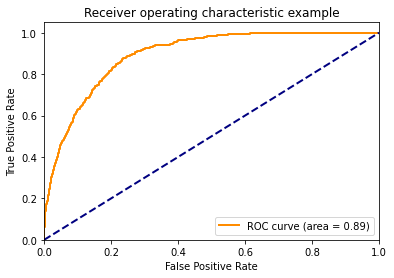

In [278]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

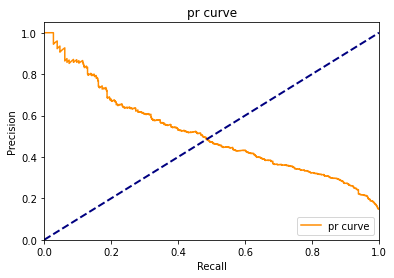

In [279]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba[:,1])
plt.plot(
    recall,
    precision,
    color="darkorange",
    
    label="pr curve",
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("pr curve")
plt.legend(loc="lower right")
plt.show()

In [280]:
f1_scores = 2*recall*precision/(recall+precision)
print('Best threshold: ', thresholds[np.argmax(f1_scores)])
print('Best F1-Score: ', np.max(f1_scores))

Best threshold:  0.23056688611730913
Best F1-Score:  0.5033921302578019
